## Visualize correlation heatmaps across profiles with metadata

Gregory Way, 2021

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(devtools))
source(file.path("utils/viz.R"))

In [2]:
# The correct version of ComplexHeatmap was not available on anaconda
# https://anaconda.org/bioconda/bioconductor-complexheatmap
# Install it here
if (!("ComplexHeatmap" %in% rownames(installed.packages()))) {
    install_github("jokergoo/ComplexHeatmap")
}

suppressPackageStartupMessages(library(ComplexHeatmap))

In [3]:
# Set constants
dataset <- "bortezomib"
data_dir <- "data"

output_dir <- file.path("figures", "heatmaps")

lgd_title_fontsize = 9
lgd_label_fontsize = 6.5
anno_name_height = 0.45

In [4]:
# Load profiles
dataset_file <- file.path(data_dir, paste0(dataset, "_signature_analytical_set.tsv.gz"))

data_cols <- readr::cols(
    .default = readr::col_double(),
    Metadata_Plate = readr::col_character(),
    Metadata_Well = readr::col_character(),
    Metadata_cell_count = readr::col_integer(),
    Metadata_batch = readr::col_character(),
    Metadata_clone_number = readr::col_character(),
    Metadata_plate_map_name = readr::col_character(),
    Metadata_treatment = readr::col_character(),
    Metadata_dataset = readr::col_character(),
    Metadata_clone_type = readr::col_character(),
    Metadata_clone_type_indicator = readr::col_character(),
    Metadata_model_split = readr::col_character(),
    Metadata_cell_density = readr::col_character(),
    Metadata_treatment_time = readr::col_character(),
    Metadata_unique_sample_name = readr::col_character(),
    Metadata_time_to_adhere = readr::col_character()
)

dataset_df <- readr::read_tsv(dataset_file, col_types=data_cols)

print(dim(dataset_df))
head(dataset_df, 3)

[1]  420 3546


Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_cell_count,Metadata_cell_density,Metadata_celltype_shorthand_from_plate_graph,Metadata_clone_number,Metadata_date,Metadata_plate_map_name,Metadata_time_to_adhere,⋯,Nuclei_Texture_Variance_RNA_10_02,Nuclei_Texture_Variance_RNA_10_03,Nuclei_Texture_Variance_RNA_20_00,Nuclei_Texture_Variance_RNA_20_01,Nuclei_Texture_Variance_RNA_20_02,Nuclei_Texture_Variance_RNA_20_03,Nuclei_Texture_Variance_RNA_5_00,Nuclei_Texture_Variance_RNA_5_01,Nuclei_Texture_Variance_RNA_5_02,Nuclei_Texture_Variance_RNA_5_03
<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
219907,B02,2021_03_03_Batch12,6139,2.5x10^3 cells/well,1,WT_parental,20210205,219814,48 hr,⋯,-0.6430638,-0.6342366,-0.6554599,-0.6673215,-0.6546287,-0.6977682,-0.6320059,-0.6297243,-0.6345844,-0.6329460
219907,B03,2021_03_03_Batch12,4567,2.5x10^3 cells/well,2,CloneA,20210205,219814,48 hr,⋯,-0.8308873,-0.8344854,-0.8304672,-0.8178338,-0.8309076,-0.8234369,-0.8347194,-0.8332018,-0.8327623,-0.8296075
219907,B04,2021_03_03_Batch12,5624,2.5x10^3 cells/well,3,CloneE,20210205,219814,48 hr,⋯,-0.9813265,-0.9759700,-0.9728225,-0.9617426,-0.9721434,-0.9618017,-0.9802334,-0.9790954,-0.9839611,-0.9793490


In [5]:
# Load signatures
sig_dir <- file.path("results", "signatures")
signature_file <- file.path(sig_dir, paste0("signature_summary_", dataset, "_signature.tsv.gz"))

sig_col_types <- readr::cols(
    features = readr::col_character(),
    non_specific_exclude = readr::col_logical(),
    final_signature = readr::col_logical(),
    dataset = readr::col_character()
)

signature_df <- readr::read_tsv(signature_file, col_types = sig_col_types)

print(dim(signature_df))
head(signature_df, 4)

[1] 782   8


features,non_status_significant_exclude,batch_exclude,cell_count_exclude,non_specific_exclude,treatment_time_exclude,final_signature,dataset
<chr>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<lgl>,<chr>
Cells_AreaShape_Compactness,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,bortezomib
Cells_AreaShape_Eccentricity,TRUE,FALSE,TRUE,TRUE,FALSE,FALSE,bortezomib
Cells_AreaShape_Extent,FALSE,FALSE,FALSE,TRUE,FALSE,FALSE,bortezomib
Cells_AreaShape_FormFactor,FALSE,FALSE,TRUE,TRUE,FALSE,FALSE,bortezomib


In [6]:
# Load feature selection results
feat_file <- file.path(data_dir, "dataset_features_selected.tsv")

feat_cols <- readr::cols(
  features = readr::col_character(),
  dataset = readr::col_character()
)

features_df <- readr::read_tsv(feat_file, col_types = feat_cols)

print(dim(features_df))
head(features_df, 3)

[1] 782   2


features,dataset
<chr>,<chr>
Cells_AreaShape_Compactness,bortezomib
Cells_AreaShape_Eccentricity,bortezomib
Cells_AreaShape_Extent,bortezomib


In [7]:
# Load signature scores
score_dir <- file.path("results", "singscore")
score_file <- file.path(score_dir, paste0("singscore_results", dataset, ".tsv.gz"))

score_cols <- readr::cols(
    .default = readr::col_character(),
    Metadata_clone_type_indicator = readr::col_integer(),
    Metadata_celltype_shorthand_from_plate_graph = readr::col_integer(),
    Metadata_date = readr::col_integer(),
    Metadata_treatment_shorthand_from_plate_graph = readr::col_integer(),
    TotalScore = readr::col_double(),
    TotalDispersion = readr::col_double(),
    UpScore = readr::col_double(),
    UpDispersion = readr::col_double(),
    DownScore = readr::col_double(),
    DownDispersion = readr::col_double(),
    Metadata_permuted_p_value = readr::col_double(),
    min_permuted_value = readr::col_double(),
    max_permuted_value = readr::col_double()
)

score_df <- readr::read_tsv(score_file, col_types = score_cols)

print(dim(score_df))
head(score_df, 3)

[1] 525  28


Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_cell_count,Metadata_cell_density,Metadata_celltype_shorthand_from_plate_graph,Metadata_clone_number,Metadata_date,Metadata_plate_map_name,Metadata_time_to_adhere,⋯,TotalScore,TotalDispersion,UpScore,UpDispersion,DownScore,DownDispersion,Metadata_permuted_p_value,dataset,min_permuted_value,max_permuted_value
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
219907,B02,2021_03_03_Batch12,6139,2.5x10^3 cells/well,1,WT_parental,20210205,219814,48 hr,⋯,-0.15194809,385.4760,-0.1553199,185.3250,0.003371848,200.1510,0.941,bortezomib,-0.1548019,0.1589312
219907,B03,2021_03_03_Batch12,4567,2.5x10^3 cells/well,2,CloneA,20210205,219814,48 hr,⋯,-0.03125574,519.6513,-0.0890067,350.6349,0.057750956,169.0164,0.584,bortezomib,-0.1548019,0.1589312
219907,B04,2021_03_03_Batch12,5624,2.5x10^3 cells/well,3,CloneE,20210205,219814,48 hr,⋯,0.00999497,471.4668,-0.1017485,284.6592,0.111743482,186.8076,0.430,bortezomib,-0.1548019,0.1589312


In [8]:
# Set colors
legend_scale_cols = circlize::colorRamp2(c(-1, 0, 1), c("blue", "white", "red"))

plate_col = c(
    "219901" = "#E1DAAE",
    "219907" = "#FF934F",
    "219956" = "#CC2D35",
    "219973" = "#058ED9",
    "220039" = "#848FA2",
    "220040" = "#2D3142",
    "220055" = "#FFC857"
)
clonetype_col = c("Clone" = "#785EF0", "Parental" = "#DC267F")

# From colorbrewer2.org
spectral_palette <- c(
    '#9e0142',
    '#d53e4f',
    '#f46d43',
    '#fdae61',
    '#fee08b',
    '#ffffbf',
    '#e6f598',
    '#abdda4',
    '#66c2a5',
    '#3288bd',
    '#5e4fa2'
)

spectral_limits <- c(-1, 1) * max(abs(score_df$TotalScore))
spectral_breaks <- seq(spectral_limits[1] * 100, spectral_limits[2] * 100, length(spectral_palette) + 1) / 100

signature_col = circlize::colorRamp2(rev(spectral_breaks), spectral_palette)
sensitivity_col = c("resistant" = "#332a2a", "sensitive" = "#c3c7c9")

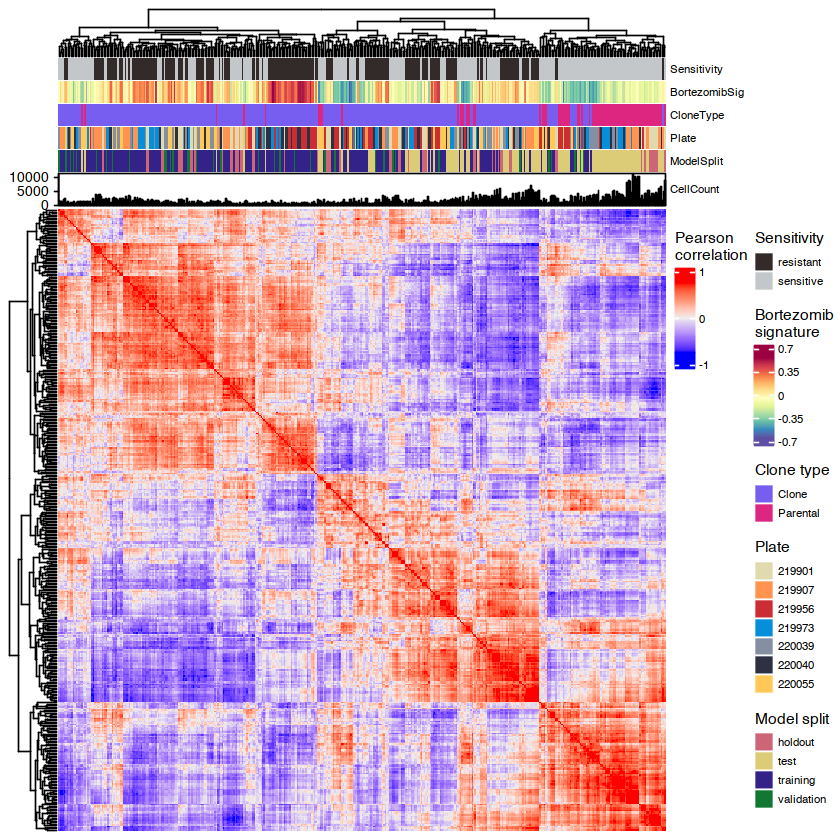

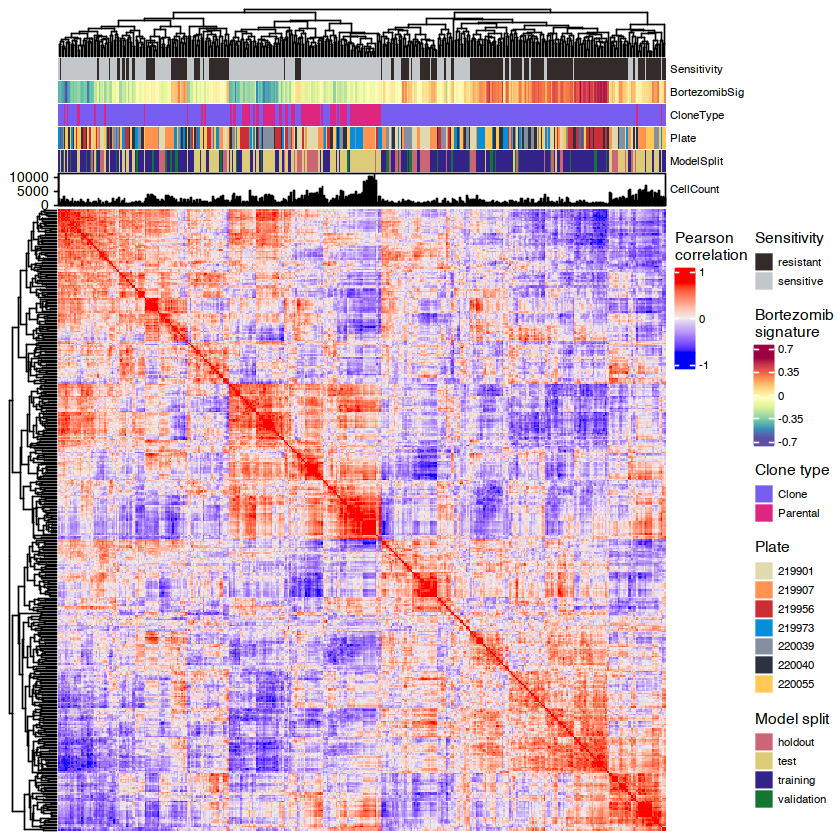

In [9]:
for (feature_select_type in c("selected", "signature")) {
    
    # Determine features that were selected for the dataset
    if (feature_select_type == "signature") {
        # Signature only features
        selected_features <- signature_df %>%
            dplyr::filter(final_signature) %>%
            dplyr::pull(features)
    } else {
        # Features that survived the standard feature selection steps
        selected_features <- features_df %>%
            dplyr::filter(dataset == !!dataset) %>%
            dplyr::pull(features)
    }

    # Subset the signature results for later merge
    subset_score_df <- score_df %>%
        dplyr::filter(dataset == !!dataset) %>%
        dplyr::select(Metadata_unique_sample_name, TotalScore)

    # Subset the data to only these features
    subset_data_df <- dataset_df %>%
        dplyr::filter(Metadata_dataset == !!dataset) %>%
        dplyr::select(starts_with("Metadata_"), !!!selected_features) %>%
        dplyr::filter(Metadata_treatment == "0.1% DMSO")  %>%
        dplyr::left_join(subset_score_df, by = "Metadata_unique_sample_name") %>%
        dplyr::mutate(Metadata_parental = "Clone")

    # Identify parental lines
    subset_data_df[grepl("parental", subset_data_df$Metadata_clone_number), "Metadata_parental"] = "Parental"

    # Obtain correlation matrix
    correlation_matrix_df <- t(subset_data_df %>% dplyr::select(!!!selected_features)) %>% cor() 
    
    # Generate the heatmap
    ht <- Heatmap(
        correlation_matrix_df,
        name = "Correlation",
        column_dend_side = "top",
        # To generate heatmaps sorted by signature score
        # row_order = order(subset_data_df$TotalScore),
        # column_order = order(subset_data_df$TotalScore),
        clustering_method_columns = "average",
        clustering_method_rows = "average",

        top_annotation = HeatmapAnnotation(
            Sensitivity = subset_data_df$Metadata_clone_type,
            BortezomibSig = subset_data_df$TotalScore,
            CloneType = subset_data_df$Metadata_parental,
            Plate = subset_data_df$Metadata_Plate,
            ModelSplit = subset_data_df$Metadata_model_split,
            CellCount = anno_barplot(
                subset_data_df$Metadata_cell_count,
                height = unit(anno_name_height * 1.5, "cm")
            ),

            annotation_legend_param = list(
                ModelSplit = list(
                    title_gp = gpar(fontsize = lgd_title_fontsize),
                    labels_gp = gpar(fontsize = lgd_label_fontsize),
                    title = "Model split"
                ),
                Sensitivity = list(
                    title_gp = gpar(fontsize = lgd_title_fontsize),
                    labels_gp = gpar(fontsize = lgd_label_fontsize)
                ),
                Plate = list(
                    title_gp = gpar(fontsize = lgd_title_fontsize),
                    labels_gp = gpar(fontsize = lgd_label_fontsize)
                ),
                CloneType = list(
                    title_gp = gpar(fontsize = lgd_title_fontsize),
                    labels_gp = gpar(fontsize = lgd_label_fontsize),
                    title = "Clone type"
                ),
                BortezomibSig = list(
                    title_gp = gpar(fontsize = lgd_title_fontsize),
                    labels_gp = gpar(fontsize = lgd_label_fontsize),
                    col_fun = signature_col,
                    title = "Bortezomib\nsignature",
                    at = c(-0.7, -0.35, 0, 0.35, 0.7)
                )
            ),

            col = list(
                ModelSplit = legend_colors,
                BortezomibSig = signature_col,
                Plate = plate_col,
                CloneType = clonetype_col,
                Sensitivity = sensitivity_col
            ),

            simple_anno_size = unit(anno_name_height, "cm"),
            annotation_name_gp = gpar(fontsize = lgd_label_fontsize)
        ),
        
        heatmap_legend_param = list(
            title = "Pearson\ncorrelation",
            color_bar = "continuous",
            col_fun = legend_scale_cols,
            title_gp = gpar(fontsize = lgd_title_fontsize),
            title_position = "topleft",
            labels_gp = gpar(fontsize = lgd_label_fontsize),
            at = c(-1, 0, 1)
        )
    )

    # Save heatmap to file
    fig_file <- file.path(
        output_dir, paste0("heatmap_", dataset, "_features_",  feature_select_type, ".pdf")
    )
    pdf(fig_file)
    draw(ht)
    dev.off()

    draw(ht)
}